In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle

In [2]:
class MountCarRL:
    
    def __init__(self):
        # setting up the environment
        print(" choose the environment: ")
        print("0: MountainCar-v0")
        
        self.choice = input()
        if self.choice == "0":
            self.env = gym.make("MountainCar-v0")
        else:
            raise EnvironmentError("Invalid Input!!!")
           
        # plotting booleans
        self.q_learning = False
        self.sarsa = False
        self.d_sarsa = False
        self.ACS = False
        
        self.dim = self.env.observation_space.shape[0]
        
        self.max = self.env.observation_space.high
        self.min = self.env.observation_space.low
        
        self.num_actions = self.env.action_space.n
    
    def SolveWithQLearning(self, step_size=0.01, state_discretization=20,
                           init_q_table=None, episodes=30000, display_every=2000,
                           discount=0.95, epsilon=0.05):
        
        self.q_learning = True
        
        if self.choice == "0":
            self.env = gym.make("MountainCar-v0")
        
        # epsilon equal '0' = greedy method 
        
        self.q_table_size = [state_discretization for _ in range(self.dim)] + [self.num_actions]
        self.q_learning_episodes = episodes
        self.q_learning_discount = discount
        self.q_learning_epsilon = epsilon
        
        if init_q_table is None:
            # creating a q_table
            self.q_table = self.CreateQ_Table(self.q_table_size)
        else:
            self.q_table = init_q_table
        
        # discrete window sizes of position and velocity
        self.window_sizes = (self.max - self.min) / self.q_table_size[:self.dim]
    
        self.Q_Table_rewards = []
        
        # training
        for i in range(self.q_learning_episodes):
            
            done = False
            # current state
            discrete_current_state = self.GetDiscreteStates(self.env.reset())
            current_action = 0
            
            # sleceting an action to take according to the desired method
            if np.random.random() <= self.q_learning_epsilon:
                current_action = np.random.randint(self.num_actions)
            else:
                current_action = np.argmax(self.q_table[discrete_current_state])

                        
            reward_per_episode = 0

            while not done:
                
                new_state, reward, done, _ = self.env.step(current_action)
                # discretizing new state
                discrete_new_state = self.GetDiscreteStates(new_state)
                new_action = np.argmax(self.q_table[discrete_new_state])
                
                if not done:
                    # updating state-action values according to the bellman equation
                    self.q_table[discrete_current_state][current_action] += step_size * (reward + 
                                                                            self.q_learning_discount * self.q_table[discrete_new_state][new_action]
                                                                           - self.q_table[discrete_current_state][current_action])

                    discrete_current_state = deepcopy(discrete_new_state)
                    
                    # selecting the next action to take
                    if np.random.random() < self.q_learning_epsilon:
                        current_action = np.random.randint(self.num_actions)
                    else:
                        # current_action = np.argmax(self.q_table[discrete_current_state])
                        current_action = new_action

                elif new_state[0] >= self.env.goal_position:
                     # self.q_table[discrete_current_state][current_action] = 0
                    self.q_table[discrete_current_state][current_action] += step_size * (reward 
                                                                           - self.q_table[discrete_current_state][current_action])

                
                if i % display_every == 0:
                    self.env.render()
                # accumulating rewards   
                reward_per_episode += reward
            
            self.Q_Table_rewards.append(reward_per_episode)
            
        self.env.close()
    
    # SARSA and Tile Coding
    # episodic semi-gradient SARSA for estimating q
    def SolveWith_SARSA_TileCoding(self, num_tilings=8, step_size=0.01, num_tiles=10,
                            offsets=None, episodes=30000, display_every=3000, epsilon=0.05, discount=0.95):
        
        self.sarsa = True
        
        if self.choice == "0":
            self.env = gym.make("MountainCar-v0")
        
        
        self.sarsa_num_tilings = num_tilings
        self.sarsa_step_size = step_size / num_tilings
        self.sarsa_num_tiles = num_tiles
        self.sarsa_epsilon = epsilon
        self.sarsa_episodes = episodes
        self.sarsa_discount = discount
        
        if offsets is None:
            # uniform offset tiling
            sizes = (self.max-self.min) / (self.sarsa_num_tilings*self.sarsa_num_tiles)
            self.sarsa_offsets = [(i - self.sarsa_num_tilings/2) * sizes for i in range(self.sarsa_num_tilings)]

        else:
            self.sarsa_offsets = offsets
            
        # initializing tilings and weights
        self.sarsa_tilings = self.CreateTilings(self.sarsa_num_tilings, self.sarsa_num_tiles, self.sarsa_offsets)
        self.sarsa_weights = np.zeros((self.num_actions, self.sarsa_num_tilings * self.sarsa_num_tiles**self.dim))
        
        self.sarsa_rewards = []
        
        # training
        for i in range(self.sarsa_episodes):
            
            reward_per_episode = 0
            
            done = False
            # initial state and action
            current_state = self.env.reset()
            current_active_tiles = self.GetActiveTiles(current_state, "sarsa")
            current_action, current_action_values = self.SelectAction(current_active_tiles, "sarsa")
            
            while not done:
                
                new_state, reward, done, _ = self.env.step(current_action)
                new_active_tiles = self.GetActiveTiles(new_state, "sarsa")
                new_action, new_action_values = self.SelectAction(new_active_tiles, "sarsa")
                
                if not done:

                    TD_error = reward+self.sarsa_discount*new_action_values[new_action]-current_action_values[current_action]
                    # binary representation of active tiles for the selected action
                    x = np.zeros_like(self.sarsa_weights).astype(np.int64)
                    x[current_action][current_active_tiles] = 1
                
                    self.sarsa_weights += self.sarsa_step_size * TD_error * x
                    
                    # or we could just write
                    # self.sarsa_weights[current_action][current_active_tiles] += self.sarsa_step_size * (reward + self.sarsa_discount * new_action_values[new_action] - current_action_values[current_action])
                    
    
                    current_state = new_state
                    current_active_tiles = deepcopy(new_active_tiles)
                    current_action = new_action
                    current_action_values = deepcopy(new_action_values)
                
                elif new_state[0] >= self.env.goal_position:
                    
                    TD_error = reward-current_action_values[current_action]
                    # binary representation of active tiles for the selected action
                    x = np.zeros_like(self.sarsa_weights).astype(np.int64)
                    x[current_action][current_active_tiles] = 1
                
                    self.sarsa_weights += self.sarsa_step_size * TD_error * x
                    
                    # or we could just write
                    # self.sarsa_weights[current_action][current_active_tiles] += self.sarsa_step_size * (reward - current_action_values[current_action])
                
                if i % display_every == 0:
                    self.env.render()

                
                reward_per_episode += reward
            
            self.sarsa_rewards.append(reward_per_episode)
    
    
        self.env.close()
        
    # SARSA with TileCoding
    # Differential semi_gradient SARSA for estimating q
    def SolveWith_Diff_SARSA_TileCoding(self, num_tilings=8, alpha=0.01, beta=0.01, num_tiles=10,
                            offsets=None, episodes=30000, display_every=3000, epsilon=0.05, discount=1.):
        
        self.d_sarsa = True
        
        if self.choice == "0":
            self.env = gym.make("MountainCar-v0")
        
        
        self.d_sarsa_num_tilings = num_tilings
        self.d_sarsa_alpha = alpha / num_tilings
        self.d_sarsa_beta = beta
        self.d_sarsa_num_tiles = num_tiles
        self.d_sarsa_epsilon = epsilon
        self.d_sarsa_episodes = episodes
        self.d_sarsa_discount = discount
        
        if offsets is None:
            # uniform offset tiling
            sizes = (self.max-self.min) / (self.d_sarsa_num_tilings*self.d_sarsa_num_tiles)
            self.d_sarsa_offsets = [(i-self.d_sarsa_num_tilings/2) * sizes for i in range(self.d_sarsa_num_tilings)]

        else:
            self.d_sarsa_offsets = offsets
            
        # initializing tilings and weights
        self.d_sarsa_tilings = self.CreateTilings(self.d_sarsa_num_tilings, self.d_sarsa_num_tiles, self.d_sarsa_offsets)
        self.d_sarsa_weights = np.zeros((self.num_actions, self.d_sarsa_num_tilings * self.d_sarsa_num_tiles**self.dim))
        
        self.d_sarsa_rewards = []
        
        avg_reward = 0
        
        # training
        for i in range(self.d_sarsa_episodes):
            
            reward_per_episode = 0
            
            done = False
            # initial state and action
            current_state = self.env.reset()
            current_active_tiles = self.GetActiveTiles(current_state, "d_sarsa")
            current_action, current_action_values = self.SelectAction(current_active_tiles, "d_sarsa")
            
            while not done:
                
                new_state, reward, done, _ = self.env.step(current_action)
                new_active_tiles = self.GetActiveTiles(new_state, "d_sarsa")
                new_action, new_action_values = self.SelectAction(new_active_tiles, "d_sarsa")
                
                if not done:
                    # TD-error
                    delta = reward - avg_reward + self.d_sarsa_discount * new_action_values[new_action] - current_action_values[current_action]
                    avg_reward += self.d_sarsa_beta * delta
                    
                    # binary representation of active tiles for the selected action
                    x = np.zeros_like(self.d_sarsa_weights).astype(np.int64)
                    x[current_action][current_active_tiles] = 1
                
                    self.d_sarsa_weights += self.d_sarsa_alpha * delta * x
                    
                    # or we could just write
                    # self.d_sarsa_weights[current_action][current_active_tiles] += self.d_sarsa_alpha * delta

                    current_state = new_state
                    current_active_tiles = deepcopy(new_active_tiles)
                    current_action = new_action
                    current_action_values = deepcopy(new_action_values)
                
                elif new_state[0] >= self.env.goal_position:
                    delta = reward - avg_reward - current_action_values[current_action]
                    avg_reward += self.d_sarsa_beta * delta
                    
                    # binary representation of active tiles for the selected action
                    x = np.zeros_like(self.d_sarsa_weights).astype(np.int64)
                    x[current_action][current_active_tiles] = 1
                
                    self.d_sarsa_weights += self.d_sarsa_alpha * delta * x
                    
                    # or we could just write
                    # self.d_sarsa_weights[current_action][current_active_tiles] += self.d_sarsa_alpha * delta
                
                if i % display_every == 0:
                    self.env.render()

                
                reward_per_episode += reward
            
            self.d_sarsa_rewards.append(reward_per_episode)
    
    
        self.env.close()
        

    def SolveWith_Actor_Critic_softmax(self, step_sizes=[.03, .03, .1], num_tilings=10, num_tiles=10,
                                      offsets=None, epsilon=.05, discount=1., episodes=30000, display_every=3000):
        
        
        self.ACS = True
        
        if self.choice == "0":
            self.env = gym.make("MountainCar-v0")
        
        self.ACS_alphas = np.array(step_sizes) / num_tilings
        self.ACS_num_tilings = num_tilings
        self.ACS_num_tiles = num_tiles
        self.ACS_epsilon = epsilon
        self.ACS_episodes = episodes
        self.ACS_discount = discount
        
        if offsets is None:
            # uniform offset tiling
            sizes = (self.max-self.min) / (self.ACS_num_tilings*self.ACS_num_tiles)
            self.ACS_offsets = [(i-self.ACS_num_tilings/2) * sizes for i in range(self.ACS_num_tilings)]

        else:
            self.ACS_offsets = offsets
            
        # initializing tilings and weights
        self.ACS_tilings = self.CreateTilings(self.ACS_num_tilings, self.ACS_num_tiles, self.ACS_offsets)
        self.ACS_w = np.zeros((1, self.ACS_num_tilings * self.ACS_num_tiles**self.dim))
        self.ACS_theta = np.zeros((self.num_actions, self.ACS_num_tilings * self.ACS_num_tiles**self.dim))

        
        self.ACS_rewards = []
        avg_reward = 0
        
        # training
        for i in range(self.ACS_episodes):
            
            reward_per_episode = 0
            
            done = False
            # initial state and action
            current_state = self.env.reset()
            current_active_tiles = self.GetActiveTiles(current_state, "ACS")
            current_action, current_action_values = self.SelectAction(current_active_tiles, "ACS")
            
            # binary representation of active tiles
            x = np.zeros_like(self.ACS_w[0]).astype(np.int64)
            x[current_active_tiles] = 1
            
            current_state_value = (self.ACS_w @ x)[0]
            
            # or we could just write
            # current_state_value = np.sum(self.ACS_w[0][current_active_tiles])
            
            while not done:
                
                
                new_state, reward, done, _ = self.env.step(current_action)
                new_active_tiles = self.GetActiveTiles(new_state, "ACS")
#                 new_action, new_action_values = self.SelectAction(new_active_tiles, "ACS")
                
                # binary representation of new active tiles
                x = np.zeros_like(self.ACS_w[0]).astype(np.int64)
                x[new_active_tiles] = 1

                new_state_value = (self.ACS_w @ x)[0]


                # or we could just write
                # new_state_value = np.sum(self.ACS_w[0][new_active_tiles])
                
                if not done:
                    
                    
                    # TD-error
                    delta = reward - avg_reward + self.ACS_discount*new_state_value - current_state_value
                    avg_reward += self.ACS_alphas[2] * delta
                    
                    # binary representation of active tiles
                    x = np.zeros_like(self.ACS_w).astype(np.int64)
                    x[0][current_active_tiles] = 1

                    self.ACS_w += self.ACS_alphas[0] * delta * x

                    # or we could just write
                    # self.ACS_w[0][current_active_tiles] += self.ACS_alphas[0] * delta
                    
                    # binary representation of active tiles
                    x = np.zeros_like(self.ACS_theta).astype(np.int64)
                    x[:, current_active_tiles] = 1
                    
                    z = np.zeros_like(self.ACS_theta).astype(np.int64)
                    z[current_action][current_active_tiles] = 1
                    
                    derivatives = z - current_action_values * x
                                        
                    self.ACS_theta += self.ACS_alphas[1] * delta * derivatives 
                    
                    # or we could just write
                    # self.ACS_theta[:, current_active_tiles] += self.ACS_alphas[1] * delta * derivatives

                    
                    # selecting new action AFTER the upadte
                    current_state = deepcopy(new_state)
                    current_state_value = new_state_value
                    current_active_tiles = deepcopy(new_active_tiles)
                    current_action, current_action_values = self.SelectAction(current_active_tiles, "ACS")
                    
#                     # binary representation of active tiles
#                     x = np.zeros_like(self.ACS_w[0]).astype(np.int64)
#                     x[current_active_tiles] = 1

#                     current_state_value = (self.ACS_w @ x)[0]

                    # or we could just write
                    # current_state_value = np.sum(self.ACS_w[0][current_active_tiles])
                    
                
                elif new_state[0] >= self.env.goal_position:
                    
                    delta = reward - avg_reward - current_state_value
                    avg_reward += self.ACS_alphas[2] * delta
                    
                    # binary representation of active tiles
                    x = np.zeros_like(self.ACS_w).astype(np.int64)
                    x[0][current_active_tiles] = 1
                    
                    self.ACS_w += self.ACS_alphas[0] * delta * x
                    
                    # or we could just write
                    # self.ACS_w[0][current_active_tiles] += self.ACS_alphas[0] * delta
                    
                    
                    # binary representation of active tiles
                    x = np.zeros_like(self.ACS_theta).astype(np.int64)
                    x[:, current_active_tiles] = 1
                    
                    z = np.zeros_like(self.ACS_theta).astype(np.int64)
                    z[current_action][current_active_tiles] = 1
                    
                    derivatives = z - current_action_values * x
                                        
                    self.ACS_theta += self.ACS_alphas[1] * delta * derivatives
                    
                    # or we could just write
                    # # self.ACS_theta[:, current_active_tiles] += self.ACS_alphas[1] * delta * derivatives
                
                if i % display_every == 0:
                    self.env.render()

                
                reward_per_episode += reward
            
            self.ACS_rewards.append(reward_per_episode)
    
    
        self.env.close()
        
    ######### functions for q_table #########
    #########                       #########
    
    # function for creating q_table    
    def CreateQ_Table(self, size):
        return np.random.uniform(low=-2, high=0, size=size)
    
    # function for discretizing states for q_table
    def GetDiscreteStates(self, state):
        discrete_state = ((state - self.min) / self.window_sizes).astype(np.int64)
        
        return tuple(x for x in discrete_state)
    
    #########################################
    #########################################
 

    
    ####### functions for SARSA tile coding #######
    #########                       #########
    
    # function for creating tilings
    def CreateTilings(self, num_tilings, num_tiles, offsets):
        
        default_tiling = np.array([np.linspace(start=self.min[i], stop=self.max[i], num=num_tiles-1)[:num_tiles-2] for i in range(self.dim)])
        
        tilings = []
        # creating the rest of the tilings
        for i in range(num_tilings):
            tilings.append(np.array([default_tiling[j] + offsets[i][j] for j in range(self.dim)]))
            
        return np.array(tilings)
 



    # function for getting active tiles as a list
    def GetActiveTiles(self, state, method):
        active_tiles = []
        
        if method == "sarsa":
            tilings = self.sarsa_tilings
            num_tiles = self.sarsa_num_tiles
            
        elif method == "d_sarsa":
            tilings = self.d_sarsa_tilings
            num_tiles = self.d_sarsa_num_tiles
        
        elif method == "ACS":
            tilings = self.ACS_tilings
            num_tiles = self.ACS_num_tiles
            
        for i, tiling in enumerate(tilings):
            tile = np.zeros(self.dim)

            
            for j in range(self.dim):
                           
                if tiling[j][0] < state[j] < tiling[j][-1]:
                    tile[j] = int(num_tiles * (state[j] - tiling[j][0]) / (tiling[j][-1] - tiling[j][0]))
                           
                elif tiling[j][-1] < state[j]:
                    tile[j] = len(tiling[j]) - 1

            
            active_tile = i * num_tiles**self.dim
                           
            for k in range(self.dim):
                active_tile += tile[k] * num_tiles**k

            active_tiles.append(active_tile)
            
        return np.array(active_tiles).astype(np.int64)
   


    # a function to select action
    def SelectAction(self, active_tiles, method):
        action = 0
        action_values = []
        
        # loops `self.num_actions` times
        # calculates W.T @ X for each action where X is the binary representation of the active and deactive tiles
        # for simplicity we do not preform W.T @ X, instead we perform the equivalent operation below
        
        if method == "sarsa":
            weights = self.sarsa_weights
            epsilon = self.sarsa_epsilon
            
        elif method == "d_sarsa":
            weights = self.d_sarsa_weights
            epsilon = self.d_sarsa_epsilon
            
        elif method == "ACS":
            weights = self.ACS_theta
            epsilon = self.ACS_epsilon
            
            
        for action_value in weights:
            # binary representation of tiles, activ tiles are `1` and deactive tiles are `0`
            x = np.zeros_like(action_value).astype(np.int64)
            x[active_tiles] = 1
            # W.T @ X
            WX = action_value.T @ x
                           
            action_values.append(WX)
            # or we could just write the code below            
            # action_values.append(np.sum(action_value[active_tiles]))
       
        action_values = np.array(action_values).reshape(self.num_actions, 1)
                           
        if method == "ACS":
            action_values = self.softmax(action_values)
            action = np.random.choice(self.num_actions, p=action_values[:, 0])
            
        else:
            if np.random.random() < epsilon:
                action = np.random.choice(self.num_actions)

            else:
                action = np.argmax(action_values)

            
        return action, action_values
   



    def test(self, method):
        
        env = gym.make("MountainCar-v0")
        
        if method == "q_learning":
            done = False
            # current state
            discrete_current_state = self.GetDiscreteStates(env.reset())
            current_action = 0
            
            # sleceting an action to take according to the desired method
            current_action = np.argmax(self.q_table[discrete_current_state])
        
            while not done:
                
                new_state, reward, done, _ = env.step(current_action)
                # discretizing new state
                discrete_new_state = self.GetDiscreteStates(new_state)
                new_action = np.argmax(self.q_table[discrete_new_state])
                
                if not done:
                    
                    discrete_current_state = deepcopy(discrete_new_state)
                    current_action = new_action

                env.render()
            env.close()
            
        else:
            done = False
            current_state = env.reset()
            current_active_tiles = self.GetActiveTiles(current_state, method)
            current_action, _ = self.SelectAction(current_active_tiles, method)
            
            while not done:
                
                new_state, reward, done, _ = env.step(current_action)
                new_active_tiles = self.GetActiveTiles(new_state, method)
                new_action, _ = self.SelectAction(new_active_tiles, method)
                
                if not done:
                    current_active_tiles = deepcopy(new_active_tiles)
                    current_action = new_action

                    env.render()
            self.env.close()
            
#         elif method == "ACS":
#             pass

    def softmax(self, x):
#         x = x - np.max(x, keepdims=True)
        exp_x = np.exp(x)
        exp_x /= np.sum(exp_x, axis=0, keepdims=True)
        return exp_x
    
    #########################################
    #########################################
    
    def plot(self):
        
        if self.q_learning:
            plt.plot([i for i in range(self.q_learning_episodes//100)], [np.mean(self.Q_Table_rewards[i:i+100]) for i in range(0, self.q_learning_episodes, 100)], color="blue")
        if self.sarsa:
            plt.plot([i for i in range(self.sarsa_episodes//100)], [np.mean(self.sarsa_rewards[i:i+100]) for i in range(0, self.sarsa_episodes, 100)], color="green")
        if self.d_sarsa:
            plt.plot([i for i in range(self.d_sarsa_episodes//100)], [np.mean(self.d_sarsa_rewards[i:i+100]) for i in range(0, self.d_sarsa_episodes, 100)], color="red")
        if self.ACS:
            plt.plot([i for i in range(self.ACS_episodes//100)], [np.mean(self.ACS_rewards[i:i+100]) for i in range(0, self.ACS_episodes, 100)], color="yellow")
        
        plt.show()
        
    def plotTilings(self):
        
        prop_cycle = plt.rcParams['axes.prop_cycle']
        colors = prop_cycle.by_key()['color']
        linestyles = ['-', '--', ':']
        legend_lines = []

        fig, ax = plt.subplots(figsize=(10, 10))
        for i, grid in enumerate(self.sarsa_tilings):
            for x in grid[0]:
                l = ax.axvline(x=x, color=colors[i % len(colors)], linestyle=linestyles[i % len(linestyles)], label=i)
            for y in grid[1]:
                l = ax.axhline(y=y, color=colors[i % len(colors)], linestyle=linestyles[i % len(linestyles)])
            legend_lines.append(l)
        ax.grid('off')
        ax.legend(legend_lines, ["Tiling #{}".format(t) for t in range(len(legend_lines))], facecolor='white', framealpha=0.9)
        ax.set_title("Tilings")
        

In [3]:
mc = MountCarRL()
mc.SolveWithQLearning(episodes=15000, display_every=3000, epsilon=0.05, step_size=0.03)
mc.SolveWith_SARSA_TileCoding(episodes=15000, display_every=1500, step_size=0.03, num_tilings=4, num_tiles=16, epsilon=0.05)
mc.SolveWith_Diff_SARSA_TileCoding(episodes=15000, display_every=1500, alpha=0.03, beta=0.03, num_tilings=4, num_tiles=16, epsilon=0.05)
mc.SolveWith_Actor_Critic_softmax(num_tilings=4, num_tiles=10, episodes=15000, display_every=1500, step_sizes=[0.3, 0.2, 0.12])

 choose the environment: 
0: MountainCar-v0
0


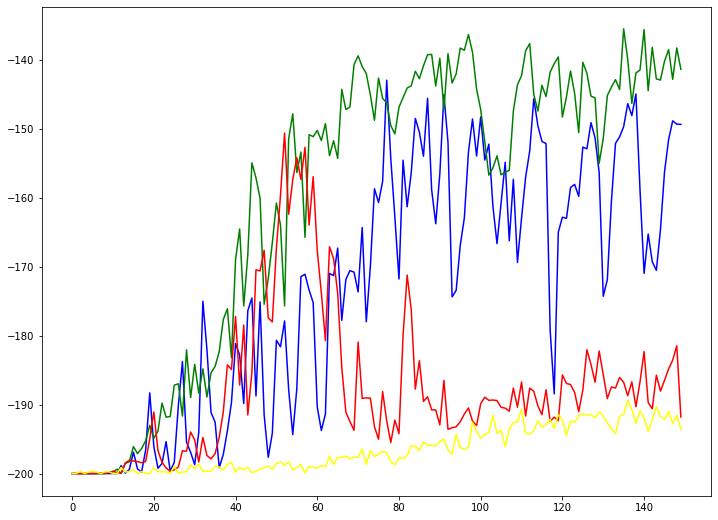

In [4]:
plt.figure(figsize=(12, 9))
mc.plot()